In [ ]:
in this file, geneating time series.
check the LSTM, Deep RNN, Simple RNN, D

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

mse = {}
mse_multistep = {}
mse_multiout = {}

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

def plot_forward(X, Y, y_preds, y_lbls, mse):
    n_steps = len(X)
    ahead = len(Y)

    plt.figure(figsize=(14,6))
    plt.plot(X, "ko-", linewidth=2, label="History")
    plt.plot([len(X)-1,len(X)],[X[-1],Y[0]]  , "k-", linewidth=2)

    
    plt.plot(np.arange(n_steps, n_steps + ahead), Y, "ro-", linewidth=2,label="Actual")
    for y_pred, ylbl in zip(y_preds,y_lbls):
        lbl = '{}, MSE={:.1e}'.format(ylbl,mse[ylbl])
        plt.plot(np.arange(n_steps-1, n_steps + ahead), np.append(X[-1], y_pred), ".-",linewidth=2,label=lbl)
    plt.axis([0, n_steps + ahead, -1, 1])

    plt.grid(True)
    plt.legend(fontsize=14,loc="best") 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


def get_data(rs,N,L_hist,L_predict,train):
    np.random.seed(rs)
    tf.random.set_seed(rs)
    
    L = L_hist + L_predict

    series = generate_time_series(N,L+1)

    X_short = np.empty((N,L_hist,1))
    y_short = np.empty((N,1,1))
    for i in range(N):
        start = np.random.randint(0,L_predict)
        X_short[i,:,:] = series[i,start:start+L_hist,:]
        y_short[i,:,:] = series[i,start+L_hist:start+L_hist+1,:]
    
    num_train = int(np.round(N*train))
    Xs_train = X_short[:num_train,:,:]
    ys_train = y_short[:num_train,:,:]
    Xs_test = X_short[num_train:,:,:]
    ys_test = y_short[num_train:,:,:]

    X = series[:N, :L_hist]
    Y = np.empty((N, L_hist, L_predict))
    for step_ahead in range(1, L_predict + 1):
        Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + L_hist, 0]
    Y = Y[:N]
    
    Xl_train = X[:num_train,:,:]
    Yl_train = Y[:num_train,:,:]
    Xl_test = X[num_train:,:,:]
    Yl_test = Y[num_train:,:,:]

    return Xs_train, ys_train, Xs_test, ys_test, Xl_train, Yl_train, Xl_test, Yl_test

def get_mse(model, X, y_test):
    y_pred = model.predict(X)
    return np.mean((ys_test[:,0,0]-y_pred[:,0])**2)

def step_forward(model, X, test_index):
    y = list()
    for step_ahead in range(10):
        y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
        X = np.concatenate([X, y_pred_one], axis=1)
    return X

In [4]:
L_hist = 50
L_predict = 10
N = 1000
Xs_train, ys_train, Xs_test, ys_test, Xl_train, yl_train, Xl_test, yl_test = get_data(382,N,L_hist,L_predict,0.8)


X_train = Xl_train
y_train = yl_train[:,-1,:]
X_test = Xl_test
y_test = yl_test[:,-1,:]

In [5]:
Xs_train.shape, ys_train.shape, Xs_test.shape, ys_test.shape

((800, 50, 1), (800, 1, 1), (200, 50, 1), (200, 1, 1))

In [6]:
Xl_train.shape, yl_train.shape, Xl_test.shape, yl_test.shape

((800, 50, 1), (800, 50, 10), (200, 50, 1), (200, 50, 10))

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 50, 1), (800, 10), (200, 50, 1), (200, 10))

# Plot time series

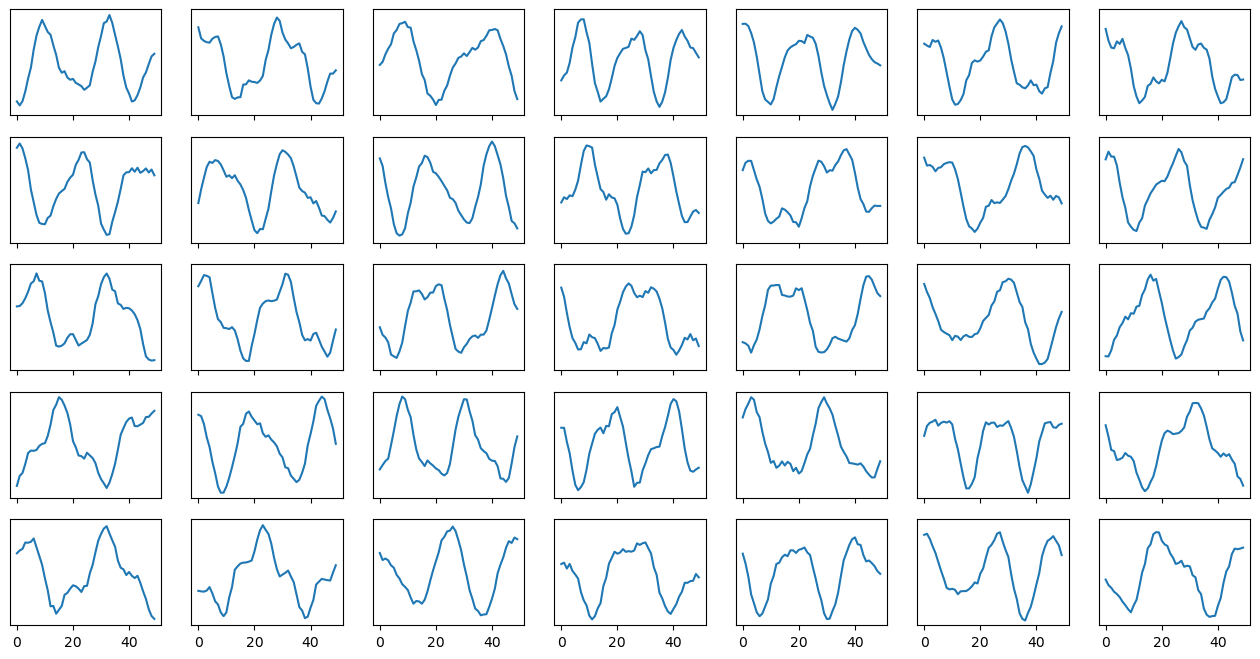

In [8]:
ax,fig = plt.subplots(nrows=5, ncols=7, figsize=(16,8),sharex=True,sharey=True)

for i, x in enumerate(Xl_train):
    
    plt.subplot(5,7,i+1)
    plt.yticks([])
    plt.plot(x)
    if i>=34:
        break

# Dense

In [9]:
model_dense = keras.models.Sequential([
              keras.layers.Flatten(input_shape=[50, 1]),
              keras.layers.Dense(1) ])

model_dense.compile(loss="mse")

model_dense.fit(X_train, y_train, epochs=20, verbose=0)

C:\Users\soheia\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Simple RNN

In [10]:
model_rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(1, input_shape=[None, 1]) ])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model_rnn.compile(loss="mse", optimizer=optimizer)

model_rnn.fit(X_train, y_train, epochs=20, verbose=0)

C:\Users\soheia\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Deep RNN

In [11]:
model_rnn_deep = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model_rnn_deep.compile(loss="mse", optimizer="adam")
model_rnn_deep.fit(X_train, y_train, epochs=25, verbose=0)

## Step forward

In [12]:
test_index = 0

In [13]:
X_dense    = step_forward(model_dense, X_test, test_index)
X_rnn      = step_forward(model_rnn, X_test, test_index)
X_rnn_deep = step_forward(model_rnn_deep, X_test, test_index)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━

In [14]:
y_dense = X_dense[test_index,-L_predict:,0]
y_rnn = X_rnn[test_index,-L_predict:,0]
y_rnn_deep = X_rnn_deep[test_index,-L_predict:,0]

In [15]:
mse_step = {}
mse_step['Dense'] = np.mean((y_test[0,:]-y_dense)**2)
mse_step['Simple RNN'] = np.mean((y_test[0,:]-y_rnn)**2)
mse_step['Deep RNN'] = np.mean((y_test[0,:]-y_rnn_deep)**2)

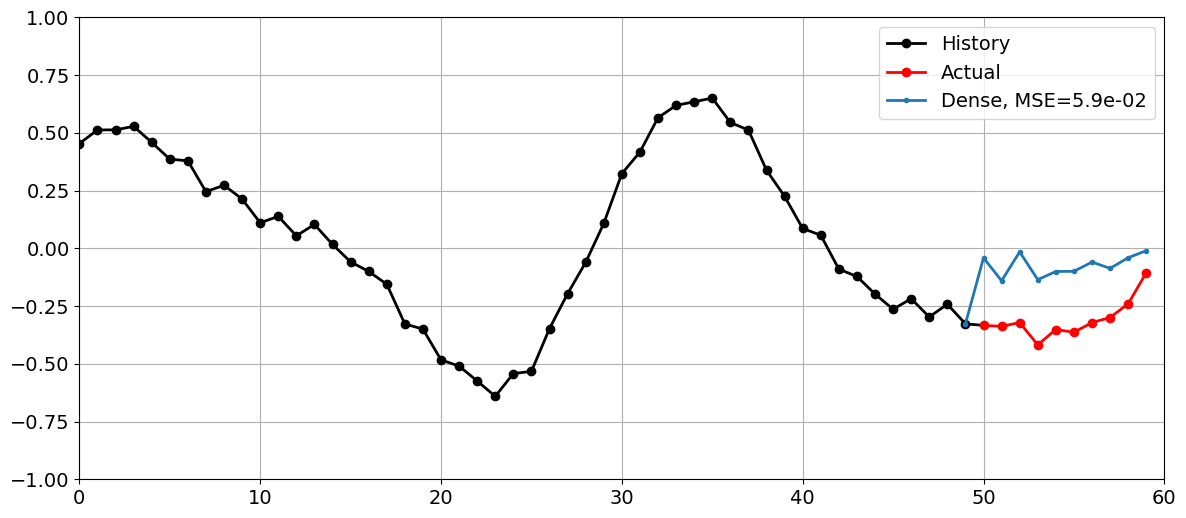

In [16]:
plot_forward(X_test[test_index,:,0], y_test[test_index,:], [y_dense], ['Dense'],mse_step)

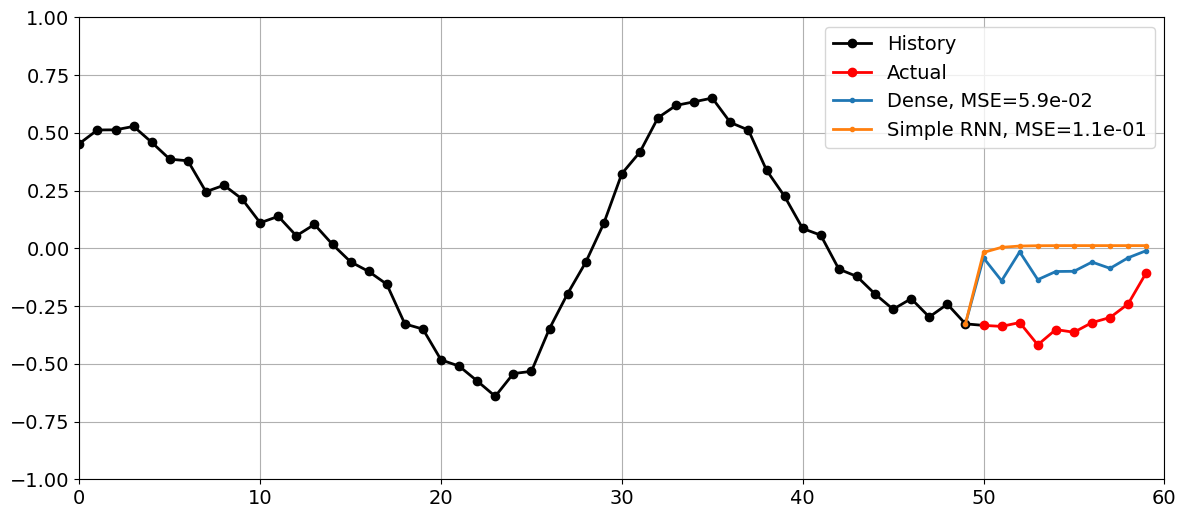

In [17]:
plot_forward(X_test[test_index,:,0], y_test[test_index,:], [y_dense,y_rnn], ['Dense','Simple RNN'],mse_step)

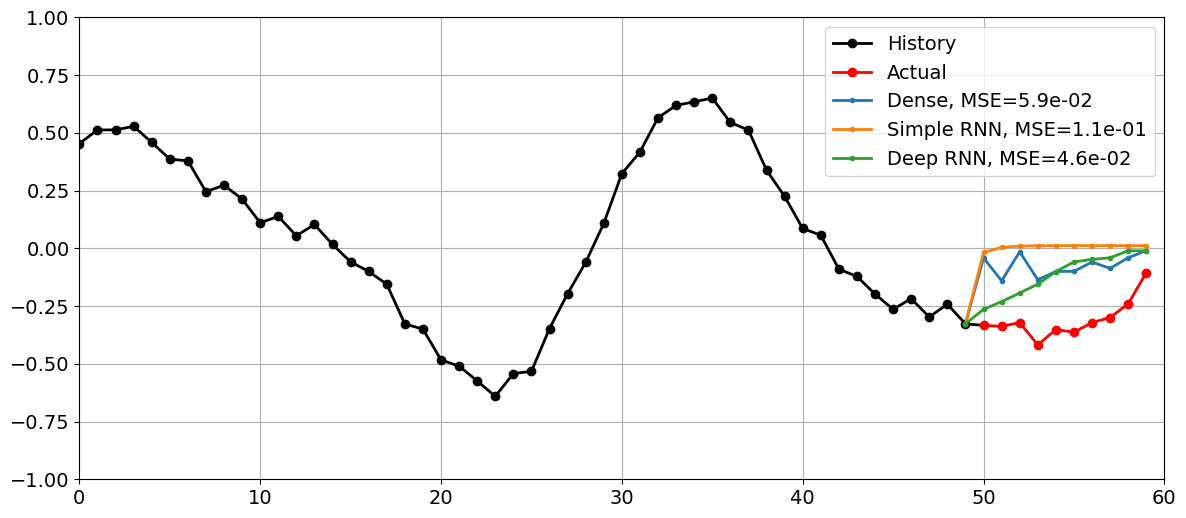

In [18]:
plot_forward(X_test[test_index,:,0], y_test[test_index,:], [y_dense,y_rnn,y_rnn_deep], ['Dense','Simple RNN','Deep RNN'],mse_step)

# Multiple time steps, all at once

# Dense multiple output

In [19]:
model_dense_multiout = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10) ])

model_dense_multiout.compile(loss="mse", optimizer="adam")
history = model_dense_multiout.fit(Xl_train, yl_train[:,-1,:], epochs=20,verbose=0)

In [20]:
y_pred_dense_multiout = model_dense_multiout.predict(Xl_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


## Deep RNN multi output

In [21]:
model_rnn_deep_multiout = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10) ])

model_rnn_deep_multiout.compile(loss="mse", optimizer="adam")
history = model_rnn_deep_multiout.fit(Xl_train, yl_train[:,-1,:], epochs=20, verbose=0)

In [22]:
y_pred_rnndeep_multiout = model_rnn_deep_multiout.predict(Xl_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


# LSTM

In [23]:
model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model_lstm.compile(loss="mse", optimizer="adam")
history = model_lstm.fit(Xl_train, yl_train, epochs=20,verbose=0)
y_pred_lstm = model_lstm.predict(Xl_test)[..., np.newaxis]

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step


In [24]:
mse_multiout = {}
mse_multiout['Dense'] = np.mean((yl_test[0,-1,:]-y_pred_dense_multiout[0])**2)
mse_multiout['Deep RNN'] = np.mean((yl_test[0,-1,:]-y_pred_rnndeep_multiout[0])**2)
mse_multiout['LSTM'] = np.mean((yl_test[0,-1,:]-y_pred_lstm[0,-1,:,0])**2)



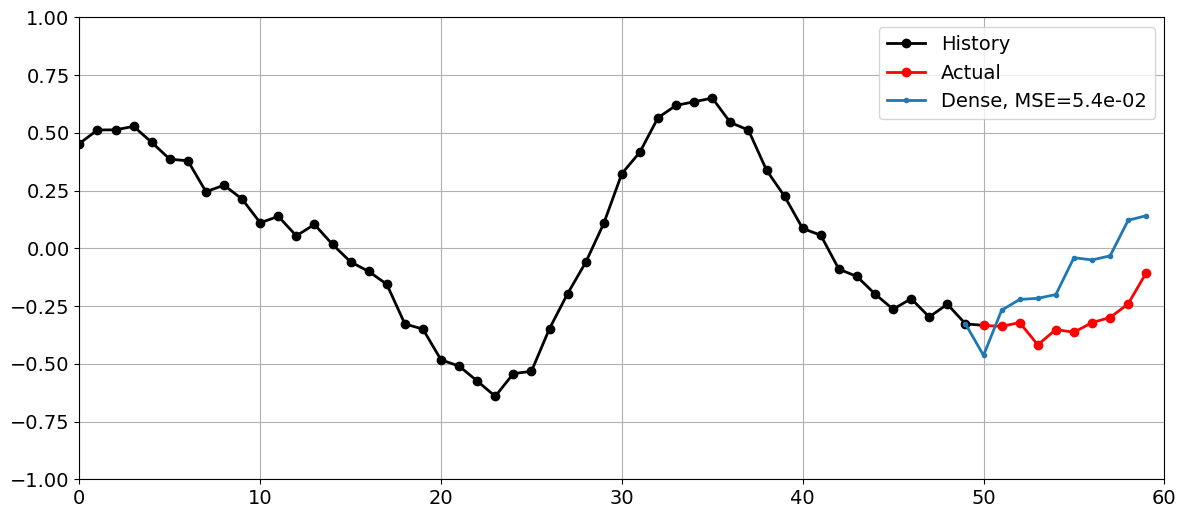

In [25]:
plot_forward(Xl_test[0,:,0], yl_test[0,-1,:], 
             [y_pred_dense_multiout[0,:]], 
             ['Dense'], mse_multiout)


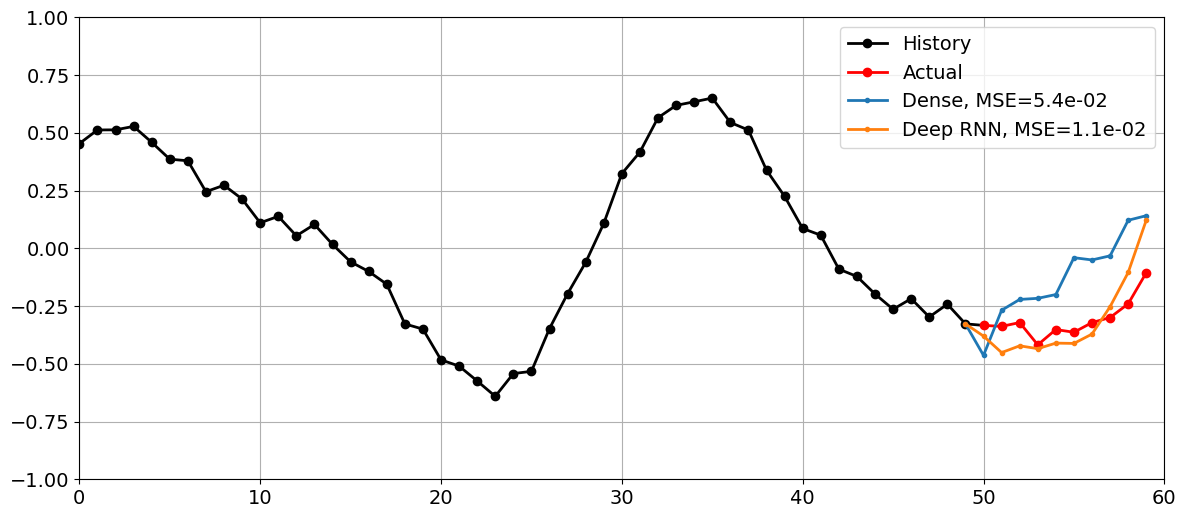

In [26]:
plot_forward(Xl_test[0,:,0], yl_test[0,-1,:], 
             [y_pred_dense_multiout[0,:], y_pred_rnndeep_multiout[0,:]], 
             ['Dense','Deep RNN'], mse_multiout)


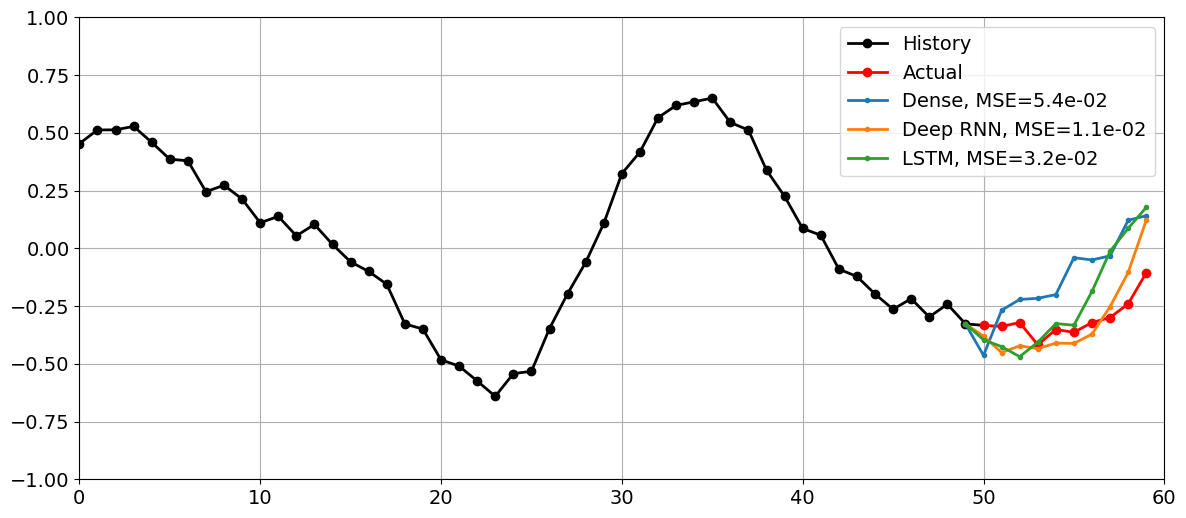

In [27]:
plot_forward(Xl_test[0,:,0], yl_test[0,-1,:], 
             [y_pred_dense_multiout[0,:], y_pred_rnndeep_multiout[0,:], y_pred_lstm[0,-1,:,0]], 
             ['Dense','Deep RNN','LSTM'], mse_multiout)
